# 3 Lane 2 motor  bidirectional flow

### @ Author - Sandip Dutta

* 16 Oct, 2020 - changed track to nested list

In [1]:
## Imports
import numpy as np
from random import random
from numpy.random import permutation
from random import shuffle
from random import choice
from collections import deque
import matplotlib.pyplot as plt
import os
import PIL
%matplotlib inline

## Simulation Parameters (Global Variables)

* Track Dimensions(numRows, numColumns) - 3 rows, 1000 columns [3 x 1000]
* maxReservoirSize - 50
* motorA, motorB - motor types
* hopMotorA, hopMotorB - Jumps of the motors
* rateMotorA, rateMotorB - Rate at which to put motors in track
* forward, backward - motor moves forward or backward

In [2]:
## Track Parameters
## numColumns set to 100, Please Change
numRows = 3
numColumns = 100

## Motor Parameters
motorA = 1
motorB = 2
vacancy = 0

## motor hop rates
hopMotorA = 1
hopMotorB = 2

## reservoir Size
maxReservoirSize = 50

## Rates of the motors
rateMotorA = 5
rateMotorB = 3

## Direction of motor Flow
forward = 1
backward = -1

## Add Reservoir for each portion of the track. 

In [3]:
## Add reservoir in the form of queue for each site in the simulation track
queue = [ [None] * numColumns] * numRows

for i in range(numRows):
    for j in range(numColumns):
        queue[i][j] = deque(maxlen = maxReservoirSize)

## Motor Class



In [4]:
## Motor object class Decalration
class Motor:
    '''Declares motors, their hop and hop direction'''
    
    def __init__(self, motorType, direction):
        '''
        @ Args : 
        motorType ~ motorType of motor (motorA / motorB)
        direction ~ forward / backward motor'''
        
        self.motorType = motorType
        self.direction = direction
        self.hop = self.hopOf(motorType) ## Negative direction means backward motor
        
    def __repr__(self):
        '''Prints the string representation of the motor'''        
        return str(self.motorType)
    
    def hopOf(self, motorType):
        ''' Returns the hop of the motor'''
        
        if self.motorType == motorA:
            return hopMotorA ## Hop of motor 1
        return hopMotorB ## Hop of motor 2

## Utility Functions

### 1. `canHopForwardSameChannel` : Function to check if motor can jump to forward site or backward site

In [5]:
def canHopForwardSameChannel(currentChannel, currentSite):
    '''
    @ Args:    
    > currentChannel, currentSite : the position of the motor    
    @ Return:    
    > val : bool, denotes if motor can jump forward or not    
        
    If motor moves in the forward direction, then check places infront
    Else check backward
    '''    
    currMotor = track[currentChannel][currentSite]  ## get current motor
    
    if currMotor == vacancy: # If no motor
        return False
    
    if currMotor.direction == 1:   ## Forward moving motor 
        val = not any(
            track[currentChannel][currentSite + 1 : currentSite + currMotor.hop + 1])
        ## forawrd space is clear
    else:
      ## Reverse motor
        val = not any(
            track[currentChannel][currentSite - currMotor.hop : currentSite]) 
        ## Reverse space is clear
    return val

### 2. `canHopToOtherChannel` : Function to check if hop to other channel or not

In [6]:
def canHopToOtherChannel(currentChannel, currentSite):
    '''
    @ Args:    
    > currentChannel, currentSite : the position of the motor    
    @ Return:    
    > bool, denotes if motor can jumo forward or not
    
    Check if motor can hop to other channel *directly* from current position.
    '''    
    currMotor = track[currentChannel][currentSite]  ### Get motor for current spot
    
    if currMotor == vacancy:
        return False
    
    jumpChannels = [0, 1, 2]
    jumpChannels.remove(currentChannel) # Remove current channel
    
    finalSite = currentSite + currMotor.hop * currMotor.direction ## direction sets backward or forward motion
    
    if finalSite >= numColumns or finalSite < 0:   ### Motor has the ability to jump out
        return True # Can hop out => Move Ahead, so true  
    
    c1, c2 = jumpChannels   # Channels to jump into after removing current position
    
    channel1 = track[c1][finalSite]  ## We assume that to jump to other channel, we need not check anything in between 
    channel2 = track[c2][finalSite]    
    return not(channel1 or channel2)

### 3. `getFinalPosition` : Function to determine the final jump position of the motor

In [7]:
def getFinalPosition(currentChannel, currentSite, sameChannel = True):
    '''
    @Args : 
    > currentChannel, currentSite : the position of the motor
    > sameChannel - if final position in same channel or different channel wanted
    @Return :
    > final position of the motor(int) or "Exit" - a special code denoting if motor needs to exit or not
    
    Gets the final position of the motor. Also determine if motor will exit or not
    '''    
    currMotor = track[currentChannel][currentSite]
    
    if currMotor == vacancy: return False   ### No motor, no hop
    
    finalSite = currentSite + currMotor.hop * currMotor.direction
    
    if finalSite >= numColumns or finalSite < 0:     # Send 'Exit' if particle can get out of track
        return "Exit"
    else:
        if sameChannel:
            return (currentChannel, finalSite)    # Final position for Same Channel
        else:
            jumpChannels = [0, 1, 2]
            jumpChannels.remove(currentChannel)    # Remove the current channel
    
            c1, c2 = permutation(jumpChannels)  ## Randomly permute the Channels
            if not track[c1][finalSite]:
                return (c1, finalSite)
            else:
                return (c2, finalSite)

### 4. `jump` : Conducts the jump between _source_ and _destination_. If particle goes out, it discards it

In [8]:
def jump(sourceChannel, sourceSite, destination):
    '''
    @ Args:
    > source - starting position of the motor
    > destination - ending position of the motor,'Exit' if goes out, else tuple
        containing final Channel to jump and final Site to jump to.
    @ Return:
    > None
    
    Conducts the jump between source and destination, if can Exit, throws motor out
    '''    
    if destination == 'Exit':
        track[sourceChannel][sourceSite] = vacancy
        return          # If can exit, throw motor out
    
    finalChannel, finalSite = destination    # If not exiting
    
    track[sourceChannel][sourceSite], track[finalChannel][finalSite] = (
        track[finalChannel][finalSite],
        track[sourceChannel][sourceSite]) ## Swaping <==> hopping

### 5. `step` : Takes the step for the motor. Whether to hopForward or change Channel or to go in Queue

In [9]:
def step(currentChannel, currentSite):
    '''
    @ Args :
    currentChannel, currentSite - current position of the particle
    @ Return :
    > None
    
    Takes the necessary action for the particle. Whether to hop forward or shift channel or go in reservoir
    '''    
    if track[currentChannel][currentSite] == vacancy:   ### If vacancy, do nothing
        return
    
    if canHopForwardSameChannel(currentChannel, currentSite):    # Go forward
        
        finalPosition = getFinalPosition(currentChannel, currentSite)  ## Exit or final destination in tuple
        jump(currentChannel, currentSite, finalPosition)  ## Jump to final position
        
    elif canHopToOtherChannel(currentChannel, currentSite):      # If obstacle, try to change lane
        
        finalPosition = getFinalPosition(currentChannel, currentSite, sameChannel = False)
        jump(currentChannel, currentSite, finalPosition)       
        
    else: 
        queue[currentChannel][currentSite].append(track[currentChannel][currentSite])    
                # In nothing happens, go in queue and wait for turn
        track[currentChannel][currentSite] = vacancy  ## As motor in reservoir, make the position empty

### 6. `queueStep` : Takes the step for the queued motors

In [10]:
def queueToChannel(currentChannel, currentSite, channelToMove):
    '''
    @Args : 
    > currentChannel, currentSite - current Position of the motor
    > channelToMove - The channel the motor will move into
    
    @Return :
    > None
    
    Moves a motor from the reservoir to the main track. 
    We assume that a motor <!--cannot exit from the reservoir-->
    '''    
    motorToMove = queue[currentChannel][currentSite][0]   ### Motor which can be popped
    
    finalSite = currentSite + motorToMove.hop * motorToMove.direction   # get final site motor can jump to
    
    if not(finalSite >= numColumns and finalSite < 0): ### If stays in track
        
        motor = queue[currentChannel][currentSite].popleft()  # Get motor 
        track[channelToMove][finalSite] = motor  # Put motor in place

### 7. `queueToSameSite` : Put motor from queue to same site but any channel in track

In [11]:
def queueToSameSite(currentChannel, currentSite, same_channel, lateral_channel):
    '''
    @Args :
    > currentChannel, currentSite - current Position of the track
    > same_channel - Threshold value for saying in the same channel
    > lateral_channel - Threshold value for going to other channel
    @Return:
    > True if successful, else False
    
    Puts a motor from reservoir to track. Motor can stay in the same site, but change channel
    '''
    
    channels = [0, 1, 2]         # All channels
    
    finalSite = currentSite   ### Final site where the motor will end up
    
    p = random()    # For random channel selection

    for channeltoMove in channels:
        if track[channeltoMove][finalSite] == vacancy:    # Check if can go to channel

            threshold = same_channel if (channeltoMove == currentChannel) else lateral_channel

            if p > threshold:
                track[channeltoMove][finalSite] = queue[currentChannel][currentSite].popleft()
                return True

    return False    # If None of this is possible

### 8. `queueStep` - Manages in and out from reservoir

In [12]:
def queueStep(currentChannel, currentSite):
    '''
    @ Args:
    > currentChannel, currentSite : Current position from where we will pop out motor
    @ Return:
    > None
    
    Manages the movement of a motor from a reservoir to the main track'''
    
    lateral_channel = 0.45  ## Threshold values for channel change
    same_channel = 0.55
    
    # Same site, different channel movement, if True return
    if queueToSameSite(currentChannel, currentSite, same_channel, lateral_channel): 
        return  

    # If HOP FORWARD in same or different channel, that is from reservoir to some site in front.
    all_channels = permutation([0, 1, 2])        # Randomly permute

    motorToEscape = queue[currentChannel][currentSite][0]   ### Motor to be moved
    finalSite = currentSite  + motorToEscape.hop * motorToEscape.direction  # final position after jump
    
    p = random()    # Generate a random number
    
    for channel in all_channels:
        if finalSite < numColumns and finalSite >= 0:   #Checks if exiting or not
            if not any(track[channel][currentSite + 1  : finalSite + 1]):
                threshold = same_channel if (channel == currentChannel) else lateral_channel
                if p > threshold:
                    queueToChannel(currentChannel, currentSite, channel)
                    return

## Simulation Codes

In [13]:
def putInTrack(motor):
    # Put motor of motorType in the track
    
    rows = permutation([0, 1, 2])

    if motor.direction == forward:
        for row in rows:
            if track[row][0] == vacancy:
                track[row][0] = motor
                break
            
    else:
        for row in rows:
            if track[row][numColumns - 1] == vacancy:
                track[row][numColumns - 1] = motor
                break   

In [15]:
# Get count of all motors of a particular type in the track
def count_motor():
    counts = [0, 0, 0]
    for i in range(numRows):
        for j in range(numColumns):
            if track[i][j] == vacancy:
                counts[0] += 1
            elif track[i][j].motorType == motorA:
                counts[1] += 1
            else:
                counts[2] += 1
    return counts    

## Fill track
Particles were added as per their rate here

In [17]:
def getTrackToPlot(track):
    track2plot = np.zeros((numRows, numColumns), dtype = np.uint8)
    for i in range(numRows):
        for j in range(numColumns):
            if track[i][j] != vacancy:
                track2plot[i][j] = track[i][j].motorType
    return track2plot            

## Bidirectional Flow Site Selector
For bidirectional flow, if we update sites like 1000 -> 999 -> 998 ... then backward flowing motors will move for each iteration. So they will exit the track and the plot will come out to be unidirectinal flow.

In [21]:
def getSiteUpdations(numCols):
    '''Get site updations list'''
    # get list of values till half of numColumns
    values_list = list(range(numCols // 2 + 1))
    sites_visiting_list = []
    
    for i in range(numCols): # For all sites
        if i % 2 == 0:
            sites_visiting_list.append(values_list[i // 2]) 
            ## Add the values of values_list sequentially
            ## At every even position            
        else:
            ## At every odd position, append numCols - 1 - last Appended Value
            sites_visiting_list.append(numCols - 1 - sites_visiting_list[-1])
    return sites_visiting_list

### Plotting Utilities

In [40]:
def plotTrack(epoch):
    '''Plotting Utility'''
    
    path = './Images_Bidirectional/'
    folder_name = 'Images_Bidirectional'
    
    if not folder_name in os.listdir():
        os.mkdir(folder_name)

    track2plot = getTrackToPlot(track) # Gets track in terms of numpy array
    
    # Add functionalities
    
    plt.title("Track")
    plt.xlabel("Lattice Site")
    plt.ylabel("Channel")
    plt.yticks([0, 1, 2])
    plt.pcolormesh(track2plot, cmap = 'Blues')
    plt.savefig(path + "track_" + str(epoch) + ".png")

In [45]:
def simulate_model(n_epochs):
    # Simulates the entire workflow
    # Make movements
    sites_visiting_sequence = getSiteUpdations(numColumns) # get site visiting list
    # print(sites_visiting_sequence)
    
    for epoch in range(n_epochs):
        
        for site in sites_visiting_sequence:  
            for channel in range(numRows):
                
                if track[channel][site] == vacancy:          # If we have empty track, then try dequeing
                    if len(queue[channel][site]) !=  0:
                        queueStep(channel, site)        # If nonempty queue, deque
                
                else:
                    step(channel, site)             # If we have any motor, take a step. Going into queue is taken care of here
                    
        if (epoch % rateMotorA == 0): putInTrack(Motor(motorA, forward))  ## Put motors as per their rate
        if (epoch % rateMotorB == 0): putInTrack(Motor(motorB, forward))
        if (epoch % rateMotorA == 0): putInTrack(Motor(motorA, backward))  ## Put motors as per their rate
        if (epoch % rateMotorB == 0): putInTrack(Motor(motorB, backward)) 
        
        
        #------------------------------------------------------
        #  Plotting of the Track
        #------------------------------------------------------
        plotTrack(epoch)
        
        
        # verification
        if epoch % 100 == 0: print(count_motor())

### Generate GIF and Create `pcolor` plots

[295, 2, 3]
[262, 21, 17]
[262, 21, 17]
0.6830658642450969


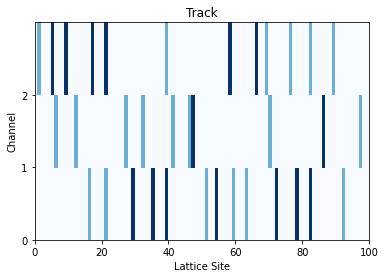

In [46]:
np.random.seed(0)
track = np.array(
    [[vacancy] * numColumns] * numRows,
    dtype = object)### Track is our model on which we place motors

from time import time
n_epochs = 300    #### The model is ran for 500 epochs here, 
start = time()
simulate_model(n_epochs)
end=time()
# Print run time
print((end - start) / float(n_epochs))  ### Average time for one epoch